## LIBRERÍAS Y CARGA DE DATOS

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

import pandas as pd
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import seaborn as sns
import glob
from google.colab import files
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc
import tensorflow as tf
from sklearn.model_selection import StratifiedKFold

In [ ]:
# Despliega el cuadro de diálogo para subir archivos
uploaded = files.upload()

# Listar los archivos subidos (opcional)
for file_name in uploaded.keys():
    print(f'Archivo subido: {file_name}')

Saving kaggle.json to kaggle (3).json
Archivo subido: kaggle (3).json


In [ ]:
# Crea la carpeta .kaggle y mueve el archivo kaggle.json
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# Cambia los permisos para el archivo kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# Instala la Kaggle CLI
!pip install -q kaggle

# Descarga el dataset utilizando el identificador del nuevo dataset
!kaggle datasets download -d preetviradiya/brian-tumor-dataset

# Descomprimir el archivo descargado
!unzip -q brian-tumor-dataset.zip -d /content/brain_tumor_dataset

Dataset URL: https://www.kaggle.com/datasets/preetviradiya/brian-tumor-dataset
License(s): GPL-2.0
brian-tumor-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)
replace /content/brain_tumor_dataset/Brain Tumor Data Set/Brain Tumor Data Set/Brain Tumor/Cancer (1).jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
def load_images_from_folder(folder, label):
    images = []
    labels = []  # Prepare a list to store the labels of the images
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename), cv2.IMREAD_GRAYSCALE)
        if img is not None:
            img = cv2.resize(img, (64, 64))  # Resize images to uniform size
            images.append(img)
            labels.append(label)
    return images, labels

tumor_path = '/content/brain_tumor_dataset/Brain Tumor Data Set/Brain Tumor Data Set/Brain Tumor'
non_tumor_path = '/content/brain_tumor_dataset/Brain Tumor Data Set/Brain Tumor Data Set/Healthy'

In [ ]:
base_dir = '/content/brain_tumor_dataset/Brain Tumor Data Set/Brain Tumor Data Set'

## EXPLORACIÓN Y VISUALIZACIÓN DE DATOS

In [ ]:
pd.DataFrame(os.listdir(base_dir),columns=['Files_Name'])

,Files_Name
0,Healthy
1,Brain Tumor


In [ ]:
files = [i for i in glob.glob(base_dir + "//*//*")]
np.random.shuffle(files)
labels = [os.path.dirname(i).split("/")[-1] for i in files]
data = zip(files, labels)
dataframe = pd.DataFrame(data, columns = ["Image", "Label"])
dataframe

,Image,Label
0,/content/brain_tumor_dataset/Brain Tumor Data ...,Brain Tumor
1,/content/brain_tumor_dataset/Brain Tumor Data ...,Healthy
2,/content/brain_tumor_dataset/Brain Tumor Data ...,Brain Tumor
3,/content/brain_tumor_dataset/Brain Tumor Data ...,Brain Tumor
4,/content/brain_tumor_dataset/Brain Tumor Data ...,Brain Tumor
...,...,...
4595,/content/brain_tumor_dataset/Brain Tumor Data ...,Brain Tumor
4596,/content/brain_tumor_dataset/Brain Tumor Data ...,Healthy
4597,/content/brain_tumor_dataset/Brain Tumor Data ...,Brain Tumor
4598,/content/brain_tumor_dataset/Brain Tumor Data ...,Healthy


<ipython-input-13-c67bdabd0ea8>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=dataframe["Label"], palette=palette)


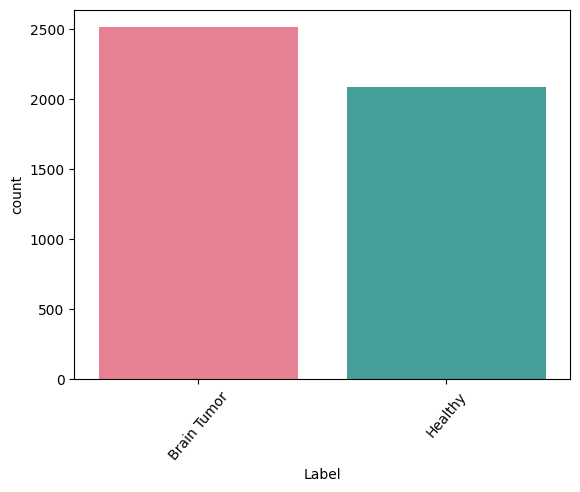

In [ ]:
# Define una paleta de colores
palette = sns.color_palette("husl", len(dataframe["Label"].unique()))

# Crea el gráfico de barras con la paleta de colores
sns.countplot(x=dataframe["Label"], palette=palette)

# Rota las etiquetas del eje x para mejorar la legibilidad
plt.xticks(rotation=50)

# Muestra el gráfico
plt.show()

In [ ]:
# Estadísticas descriptivas
dataframe.describe()

,Image,Label
count,4600,4600
unique,4600,2
top,/content/brain_tumor_dataset/Brain Tumor Data ...,Brain Tumor
freq,1,2513


In [ ]:
tumor_images, tumor_labels = load_images_from_folder(tumor_path, 1)
non_tumor_images, non_tumor_labels = load_images_from_folder(non_tumor_path, 0)

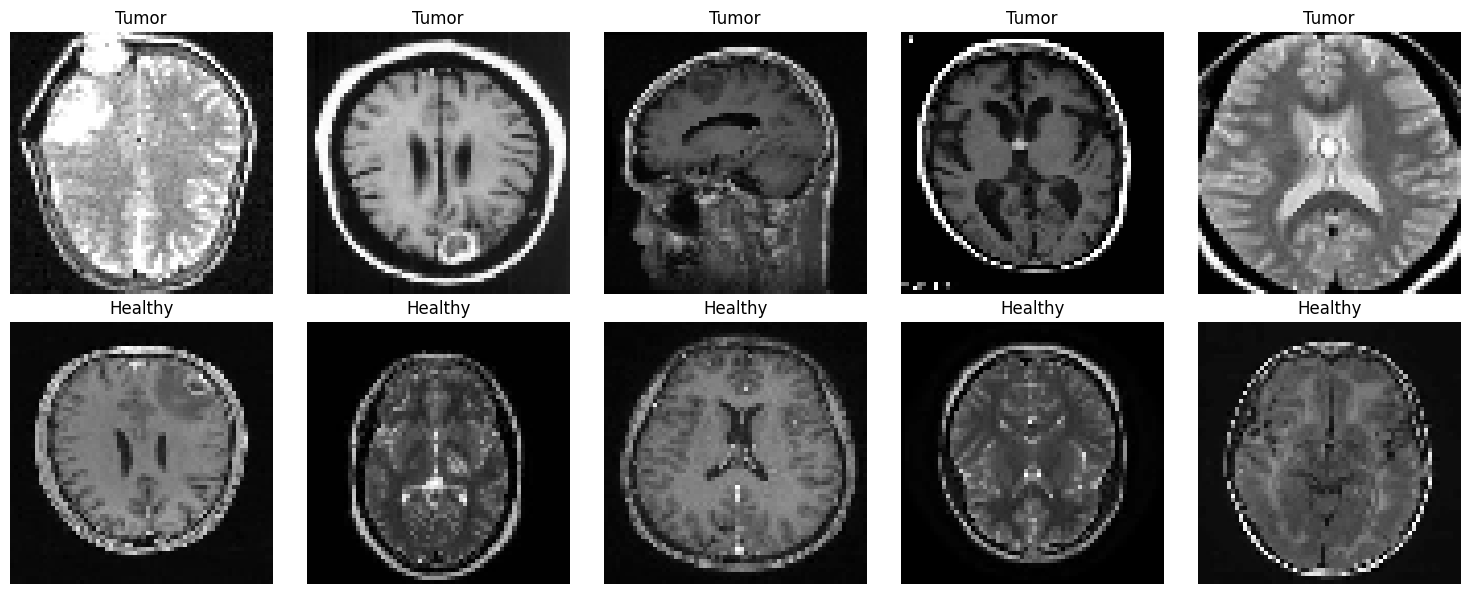

In [ ]:

fig, axes = plt.subplots(2, 5, figsize=(15, 6))  


if len(tumor_images) < 5 or len(non_tumor_images) < 5:
    raise ValueError("Not enough images loaded for displaying.")


for i in range(5):
    ax = axes[0, i]  
    ax.imshow(tumor_images[i], cmap='gray')
    ax.set_title('Tumor')
    ax.axis('off')


for i in range(5):
    ax = axes[1, i] 
    ax.imshow(non_tumor_images[i], cmap='gray')
    ax.set_title('Healthy')
    ax.axis('off')

plt.tight_layout()
plt.show()

## NORMALIZACIÓN, DIVISIÓN DEL Y PREPROCESAMIENTO DEL CONJUNTO DE DATOS

In [ ]:
images = np.array(tumor_images + non_tumor_images)
labels = np.array(tumor_labels + non_tumor_labels)

images = images / 255.0


In [ ]:

X_train, X_temp, y_train, y_temp = train_test_split(images, labels, test_size=0.4, random_state=42, stratify=labels)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)


In [ ]:
X_train = X_train.reshape(-1, 64, 64, 1)
X_test = X_test.reshape(-1, 64, 64, 1)

## **MODELO 1**

In [ ]:
model = Sequential([
    Input(shape=(64,64,1)),
    Conv2D(16, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(1, activation='sigmoid')
])
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])


In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min')


In [ ]:
history = model.fit(X_train, y_train, epochs=50,
                    validation_data=(X_val, y_val),
                    batch_size=32,
                    callbacks=[early_stopping])

Epoch 1/50
87/87 [==============================] - 9s 18ms/step - loss: 0.5965 - accuracy: 0.6768 - val_loss: 0.5038 - val_accuracy: 0.7989
Epoch 2/50
87/87 [==============================] - 1s 14ms/step - loss: 0.4426 - accuracy: 0.8076 - val_loss: 0.3909 - val_accuracy: 0.8391
Epoch 3/50
87/87 [==============================] - 1s 15ms/step - loss: 0.3895 - accuracy: 0.8319 - val_loss: 0.3634 - val_accuracy: 0.8402
Epoch 4/50
87/87 [==============================] - 1s 15ms/step - loss: 0.3452 - accuracy: 0.8583 - val_loss: 0.3294 - val_accuracy: 0.8609
Epoch 5/50
87/87 [==============================] - 1s 10ms/step - loss: 0.3090 - accuracy: 0.8728 - val_loss: 0.3417 - val_accuracy: 0.8641
Epoch 6/50
87/87 [==============================] - 1s 11ms/step - loss: 0.2692 - accuracy: 0.8993 - val_loss: 0.2904 - val_accuracy: 0.8837
Epoch 7/50
87/87 [==============================] - 1s 10ms/step - loss: 0.2568 - accuracy: 0.9007 - val_loss: 0.3086 - val_accuracy: 0.8739
Epoch 8/50
87

In [ ]:
hist_=pd.DataFrame(history.history)
hist_

,loss,accuracy,val_loss,val_accuracy
0,0.596535,0.676812,0.503812,0.798913
1,0.442595,0.807609,0.390940,0.839130
2,0.389508,0.831884,0.363420,0.840217
3,0.345185,0.858333,0.329441,0.860870
4,0.308964,0.872826,0.341659,0.864130
5,0.269242,0.899275,0.290386,0.883696
6,0.256787,0.900725,0.308603,0.873913
7,0.227062,0.918841,0.260028,0.892391
8,0.199243,0.931884,0.284891,0.891304
9,0.201134,0.925000,0.263398,0.896739


In [ ]:
# Evaluar el modelo en los datos de prueba
loss, accuracy = model.evaluate(X_test, y_test)
print("Loss en los datos de prueba:", loss)
print("Precisión en los datos de prueba:", accuracy)


29/29 [==============================] - 1s 6ms/step - loss: 0.2583 - accuracy: 0.9380
Loss en los datos de prueba: 0.2583470940589905
Precisión en los datos de prueba: 0.938043475151062


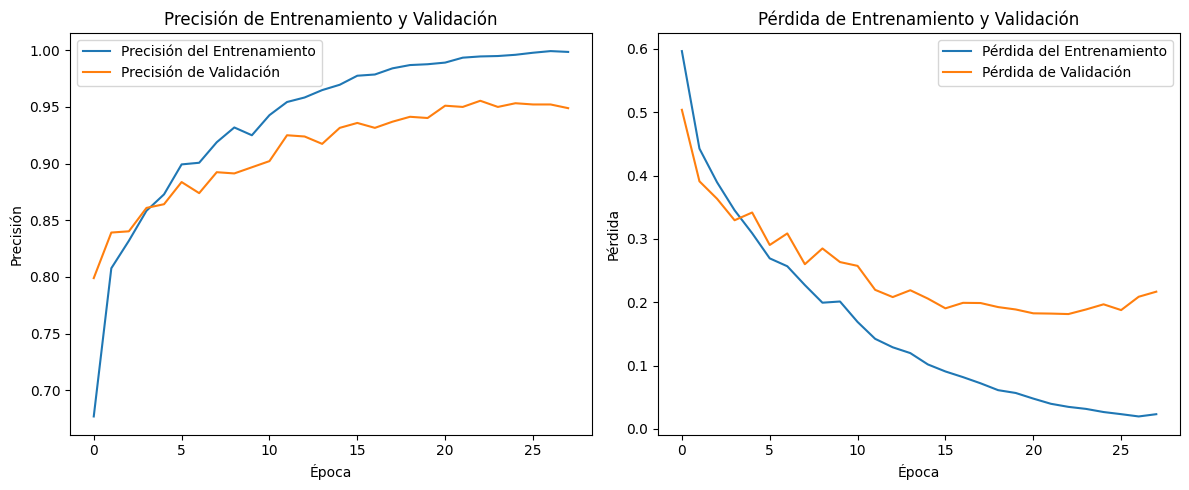

In [ ]:
# Gráfico de precisión y pérdida durante el entrenamiento y la validación
plt.figure(figsize=(12, 5))

# Precisión
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Precisión del Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Precisión de Validación')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.title('Precisión de Entrenamiento y Validación')
plt.legend()

# Pérdida
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Pérdida del Entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de Validación')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.title('Pérdida de Entrenamiento y Validación')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Realizar predicciones con salida detallada
y_pred_prob = model.predict(X_test, verbose=1)

# Convertir probabilidades en etiquetas binarias basadas en un umbral de 0.5
y_pred = (y_pred_prob > 0.5).astype(int)

# Crear un DataFrame para mostrar etiquetas reales y predichas
results = pd.DataFrame({
    'Etiqueta Actual': y_test.flatten(),  
    'Etiqueta Predicha': y_pred.flatten()
})

# Convertir las etiquetas a "Healthy" y "Tumor"
results['Etiqueta Actual'] = results['Etiqueta Actual'].map({0: 'Healthy', 1: 'Tumor'})
results['Etiqueta Predicha'] = results['Etiqueta Predicha'].map({0: 'Healthy', 1: 'Tumor'})

# Mostrar el DataFrame
results


29/29 [==============================] - 0s 4ms/step


,Etiqueta Actual,Etiqueta Predicha
0,Healthy,Healthy
1,Healthy,Healthy
2,Tumor,Tumor
3,Tumor,Tumor
4,Healthy,Healthy
...,...,...
915,Tumor,Tumor
916,Healthy,Healthy
917,Tumor,Tumor
918,Tumor,Tumor


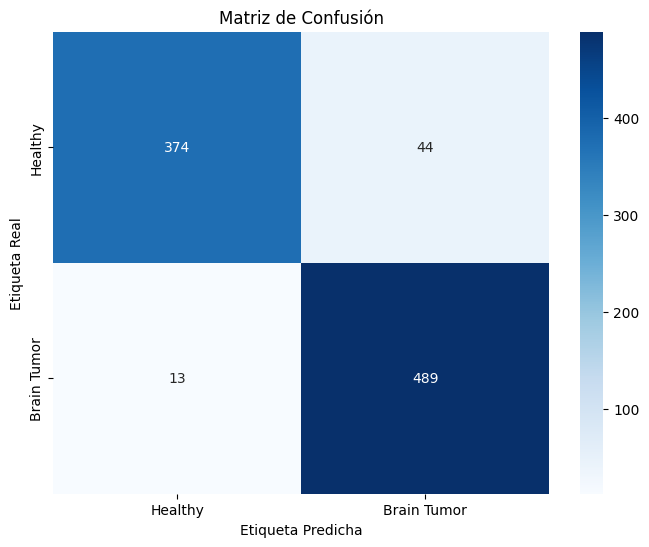

In [ ]:
# Calcular la matriz de confusión
cm = confusion_matrix(y_test, y_pred)

# Graficar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Healthy', 'Brain Tumor'], yticklabels=['Healthy', 'Brain Tumor'])
plt.title('Matriz de Confusión')
plt.xlabel('Etiqueta Predicha')
plt.ylabel('Etiqueta Real')
plt.show()

El modelo es bastante bueno en identificar correctamente tanto casos de "Brain Tumor" como "Healthy", con un buen equilibrio entre precisión y sensibilidad.

In [ ]:
# Generar el reporte de clasificación
report = classification_report(y_test, y_pred, target_names=['Healthy', 'Tumor'])
print(report)

              precision    recall  f1-score   support

     Healthy       0.97      0.89      0.93       418
       Tumor       0.92      0.97      0.94       502

    accuracy                           0.94       920
   macro avg       0.94      0.93      0.94       920
weighted avg       0.94      0.94      0.94       920



## **MODELO 2**

In [ ]:
model2 = Sequential([
    Input(shape=(64, 64, 1)),
    Conv2D(16, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Dropout(0.2),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Dropout(0.3),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Dropout(0.4),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model2.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])



In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min')


In [ ]:
history2 = model2.fit(X_train, y_train, epochs=50,
                      validation_data=(X_val, y_val),
                      batch_size=32,
                      callbacks=[early_stopping])

Epoch 1/50
87/87 [==============================] - 12s 19ms/step - loss: 0.6787 - accuracy: 0.5627 - val_loss: 0.6424 - val_accuracy: 0.6696
Epoch 2/50
87/87 [==============================] - 1s 12ms/step - loss: 0.6008 - accuracy: 0.6714 - val_loss: 0.5601 - val_accuracy: 0.7500
Epoch 3/50
87/87 [==============================] - 1s 13ms/step - loss: 0.5092 - accuracy: 0.7580 - val_loss: 0.4372 - val_accuracy: 0.8174
Epoch 4/50
87/87 [==============================] - 1s 12ms/step - loss: 0.4566 - accuracy: 0.7913 - val_loss: 0.3885 - val_accuracy: 0.8293
Epoch 5/50
87/87 [==============================] - 1s 12ms/step - loss: 0.4249 - accuracy: 0.8120 - val_loss: 0.3661 - val_accuracy: 0.8576
Epoch 6/50
87/87 [==============================] - 1s 12ms/step - loss: 0.4044 - accuracy: 0.8275 - val_loss: 0.3424 - val_accuracy: 0.8554
Epoch 7/50
87/87 [==============================] - 1s 15ms/step - loss: 0.3685 - accuracy: 0.8424 - val_loss: 0.3078 - val_accuracy: 0.8761
Epoch 8/50
8

In [ ]:
hist_=pd.DataFrame(history2.history)
hist_

,loss,accuracy,val_loss,val_accuracy
0,0.678746,0.562681,0.642442,0.669565
1,0.600755,0.671377,0.560127,0.750000
2,0.509247,0.757971,0.437167,0.817391
3,0.456625,0.791304,0.388468,0.829348
4,0.424884,0.811957,0.366128,0.857609
5,0.404369,0.827536,0.342447,0.855435
6,0.368521,0.842391,0.307814,0.876087
7,0.350861,0.855797,0.304842,0.889130
8,0.332973,0.855072,0.279837,0.892391
9,0.312769,0.871014,0.256076,0.908696


In [ ]:
# Evaluar el modelo en los datos de prueba
loss, accuracy = model2.evaluate(X_test, y_test)
print("Loss en los datos de prueba:", loss)
print("Precisión en los datos de prueba:", accuracy)


29/29 [==============================] - 0s 3ms/step - loss: 0.1066 - accuracy: 0.9641
Loss en los datos de prueba: 0.10656771808862686
Precisión en los datos de prueba: 0.9641304612159729


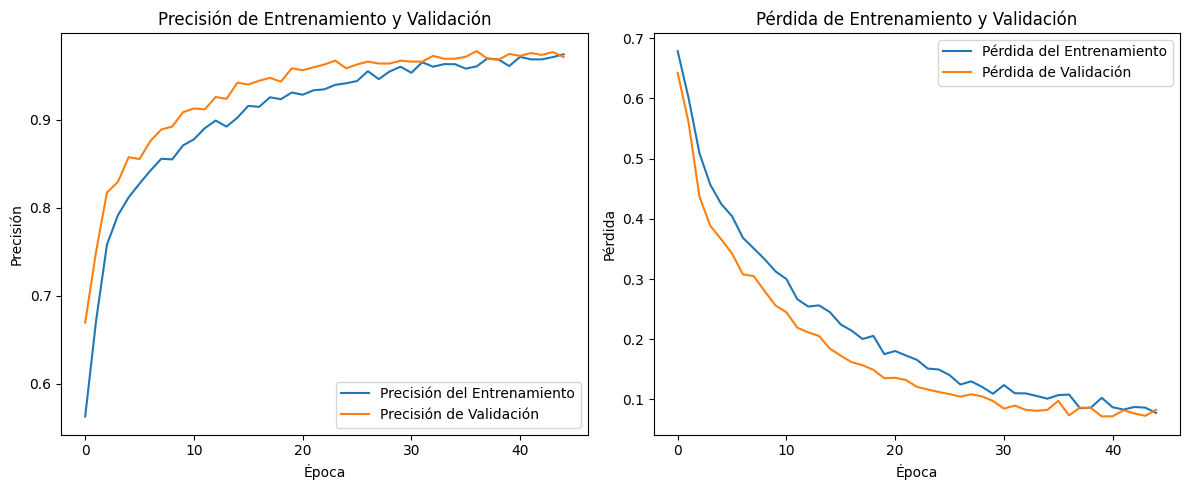

In [ ]:
# Gráfico de precisión y pérdida durante el entrenamiento y la validación
plt.figure(figsize=(12, 5))

# Precisión
plt.subplot(1, 2, 1)
plt.plot(history2.history['accuracy'], label='Precisión del Entrenamiento')
plt.plot(history2.history['val_accuracy'], label='Precisión de Validación')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.title('Precisión de Entrenamiento y Validación')
plt.legend()

# Pérdida
plt.subplot(1, 2, 2)
plt.plot(history2.history['loss'], label='Pérdida del Entrenamiento')
plt.plot(history2.history['val_loss'], label='Pérdida de Validación')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.title('Pérdida de Entrenamiento y Validación')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Realizar predicciones con salida detallada
y_pred_prob = model2.predict(X_test, verbose=1)

# Convertir probabilidades en etiquetas binarias basadas en un umbral de 0.5
y_pred = (y_pred_prob > 0.5).astype(int)

# Crear un DataFrame para mostrar etiquetas reales y predichas
results = pd.DataFrame({
    'Etiqueta Actual': y_test.flatten(),  
    'Etiqueta Predicha': y_pred.flatten()
})

# Convertir las etiquetas a "Healthy" y "Tumor"
results['Etiqueta Actual'] = results['Etiqueta Actual'].map({0: 'Healthy', 1: 'Tumor'})
results['Etiqueta Predicha'] = results['Etiqueta Predicha'].map({0: 'Healthy', 1: 'Tumor'})

# Mostrar el DataFrame
results

29/29 [==============================] - 0s 2ms/step


,Etiqueta Actual,Etiqueta Predicha
0,Healthy,Healthy
1,Healthy,Healthy
2,Tumor,Tumor
3,Tumor,Tumor
4,Healthy,Healthy
...,...,...
915,Tumor,Tumor
916,Healthy,Healthy
917,Tumor,Healthy
918,Tumor,Tumor


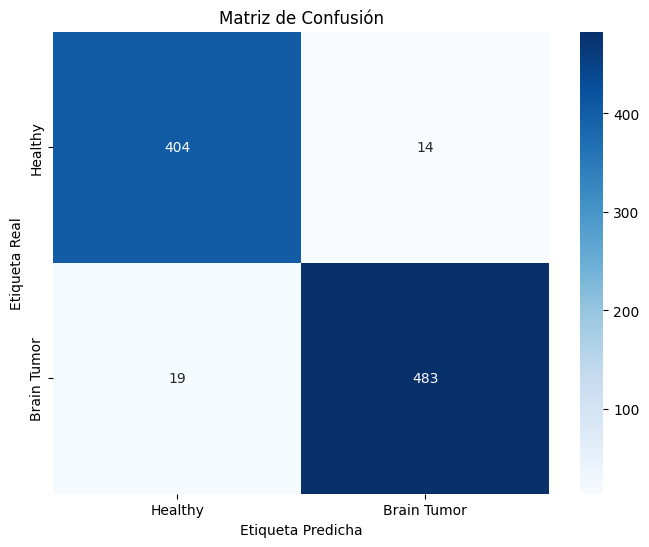

In [ ]:
# Calcular la matriz de confusión
cm = confusion_matrix(y_test, y_pred)

# Graficar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Healthy', 'Brain Tumor'], yticklabels=['Healthy', 'Brain Tumor'])
plt.title('Matriz de Confusión')
plt.xlabel('Etiqueta Predicha')
plt.ylabel('Etiqueta Real')
plt.show()

In [ ]:
# Generar el reporte de clasificación
report = classification_report(y_test, y_pred, target_names=['Healthy', 'Tumor'])
print(report)

              precision    recall  f1-score   support

     Healthy       0.96      0.97      0.96       418
       Tumor       0.97      0.96      0.97       502

    accuracy                           0.96       920
   macro avg       0.96      0.96      0.96       920
weighted avg       0.96      0.96      0.96       920



## COMPARACIÓN MODELOS

In [ ]:
def compare_models(history, history2, model, model2, X_test, y_test):
    # Comparar precisión
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Modelo 1 - Precisión en Entrenamiento')
    plt.plot(history.history['val_accuracy'], label='Modelo 1 - Precisión en Validación')
    plt.plot(history2.history['accuracy'], label='Modelo 2 - Precisión en Entrenamiento')
    plt.plot(history2.history['val_accuracy'], label='Modelo 2 - Precisión en Validación')
    plt.title('Comparación de la Precisión de los Modelos')
    plt.xlabel('Épocas')
    plt.ylabel('Precisión')
    plt.legend()

    # Comparar pérdida
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Modelo 1 - Pérdida en Entrenamiento')
    plt.plot(history.history['val_loss'], label='Modelo 1 - Pérdida en Validación')
    plt.plot(history2.history['loss'], label='Modelo 2 - Pérdida en Entrenamiento')
    plt.plot(history2.history['val_loss'], label='Modelo 2 - Pérdida en Validación')
    plt.title('Comparación de la Pérdida de los Modelos')
    plt.xlabel('Épocas')
    plt.ylabel('Pérdida')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Evaluación en el conjunto de prueba
    score1 = model.evaluate(X_test, y_test, verbose=0)
    score2 = model2.evaluate(X_test, y_test, verbose=0)
    print(f"Modelo 1 - Pérdida: {score1[0]}, Precisión: {score1[1]}")
    print(f"Modelo 2 - Pérdida: {score2[0]}, Precisión: {score2[1]}")


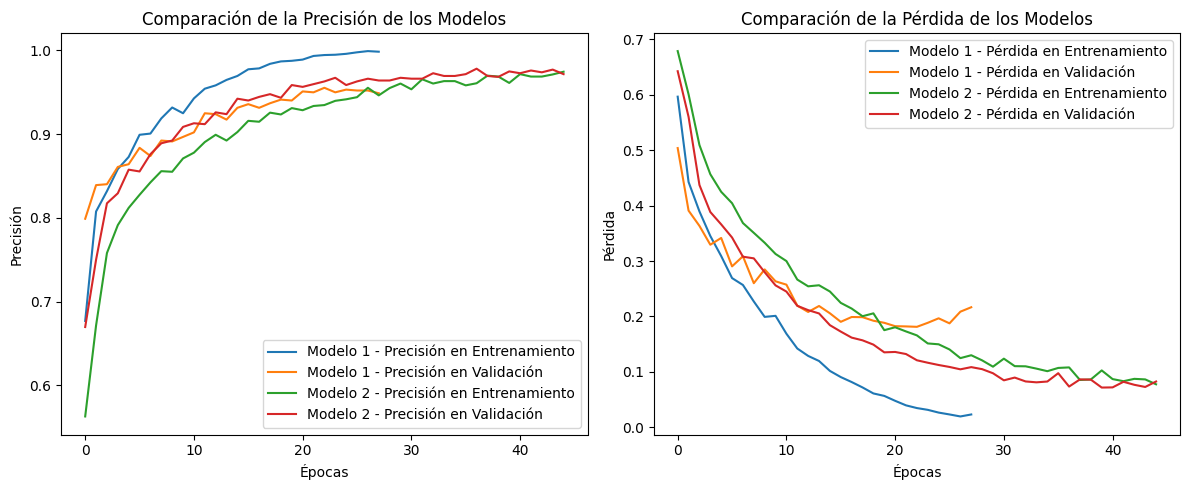

Modelo 1 - Pérdida: 0.2583470940589905, Precisión: 0.938043475151062
Modelo 2 - Pérdida: 0.10656771808862686, Precisión: 0.9641304612159729


In [ ]:
compare_models(history, history2, model, model2, X_test, y_test)

## PREDICCIÓN

In [ ]:
def prepare_image(image_path):
    """Prepara una imagen para ser evaluada por el modelo CNN."""
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is not None:
        img = cv2.resize(img, (64, 64)) 
        img = img / 255.0  
        img = np.expand_dims(img, axis=-1) 
        img = np.expand_dims(img, axis=0)  
        return img
    else:
        return None


In [ ]:
def predict_tumor_model1(image_path, model):
    """Determina si la imagen contiene un tumor utilizando el modelo CNN."""
    img = prepare_image(image_path)
    if img is not None:
        prediction = model.predict(img)
        return "Tumor" if prediction[0][0] > 0.5 else "Healthy"
    else:
        return "La imagen no se encontró o no pudo leerse"


In [ ]:
def predict_tumor_with_prob_model1(image_path, model):
    """Determina si la imagen contiene un tumor y devuelve la probabilidad de la predicción."""
    img = prepare_image(image_path)
    if img is not None:
        prediction = model.predict(img)
        probability = prediction[0][0]
        return ("Tumor", probability) if probability > 0.5 else ("Healthy", 1 - probability)
    else:
        return ("La imagen no se encontró o no pudo leerse", None)


In [ ]:
# Rutas de las imágenes
image_paths = [
    '/content/PRUEBA GL.png',
    '/content/PRUEBA MEN.png',
    '/content/PRUEBA NO CANCER.png'
]

1/1 [==============================] - 0s 28ms/step


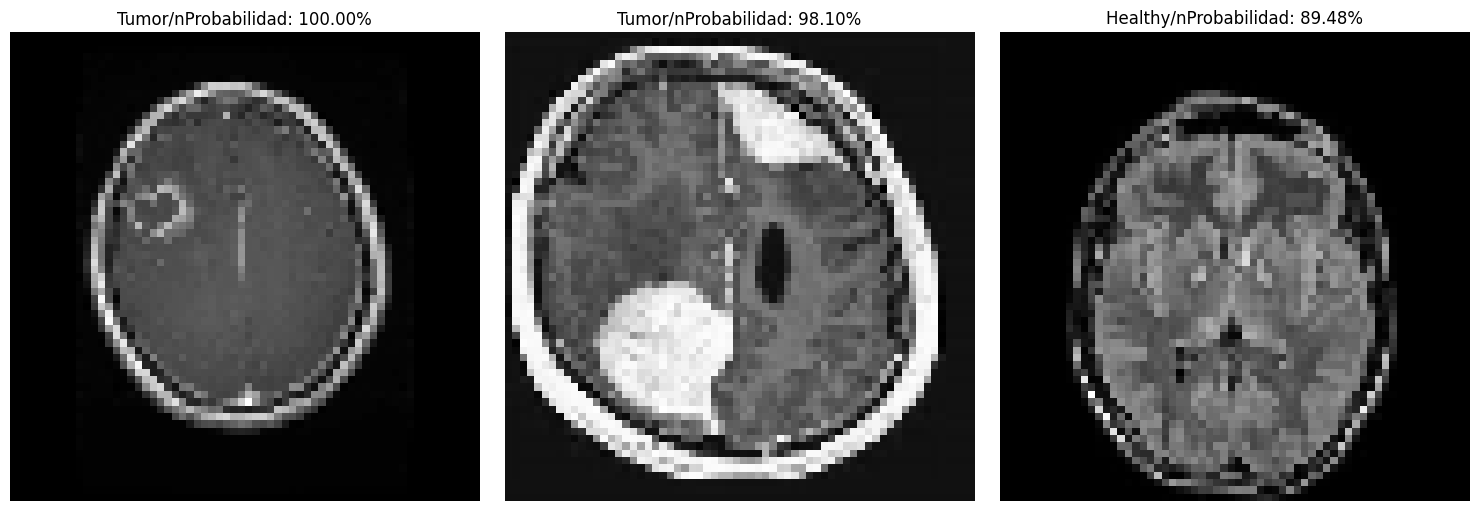

In [ ]:
# Crear subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Procesar cada imagen y mostrar
for ax, image_path in zip(axes, image_paths):
    label, prob = predict_tumor_with_prob_model1(image_path, model)
    if label != "La imagen no se encontró o no pudo leerse":
        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (64, 64))
        ax.imshow(img, cmap='gray')
        ax.title.set_text(f'{label}/nProbabilidad: {prob:.2%}')
    else:
        ax.imshow(np.zeros((64, 64)), cmap='gray')
        ax.title.set_text(label)
    ax.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
def predict_tumor_model2(image_path, model2):
    """Determina si la imagen contiene un tumor utilizando el modelo CNN."""
    img = prepare_image(image_path)
    if img is not None:
        prediction = model2.predict(img)
        return "Tumor" if prediction[0][0] > 0.5 else "Healthy"
    else:
        return "La imagen no se encontró o no pudo leerse"

In [ ]:
def predict_tumor_with_prob_model2(image_path, model2):
    """Determina si la imagen contiene un tumor y devuelve la probabilidad de la predicción."""
    img = prepare_image(image_path)
    if img is not None:
        prediction = model2.predict(img)
        probability = prediction[0][0]
        return ("Tumor", probability) if probability > 0.5 else ("Healthy", 1 - probability)
    else:
        return ("La imagen no se encontró o no pudo leerse", None)


1/1 [==============================] - 0s 19ms/step


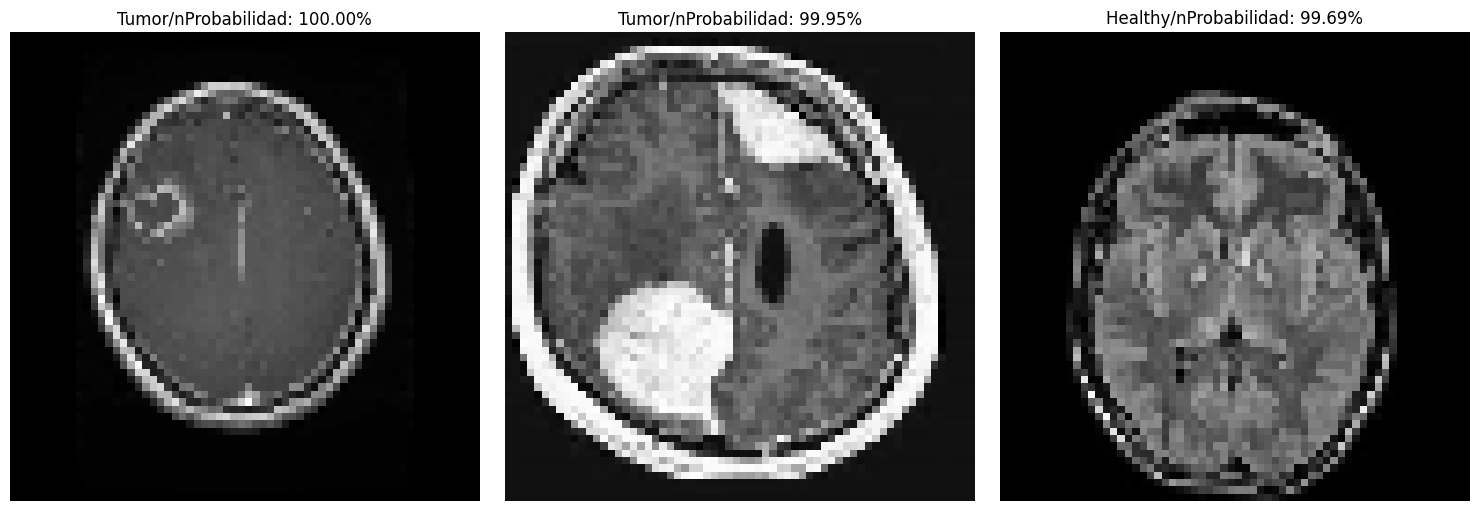

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Procesar cada imagen y mostrar
for ax, image_path in zip(axes, image_paths):
    label, prob = predict_tumor_with_prob_model2(image_path, model2)
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (64, 64))  # Asegura que todas las imágenes se muestren al mismo tamaño

    ax.imshow(img, cmap='gray')
    ax.title.set_text(f'{label}/nProbabilidad: {prob:.2%}')
    ax.axis('off')

plt.tight_layout()
plt.show()

# **ANÁLISIS CURVAS ROC - AUC: Evaluar la capacidad de discriminación de los modelos**

In [ ]:
def plot_roc_curve(model, X_test, y_test):
    # Predecir probabilidades para el conjunto de prueba
    y_pred_probs = model.predict(X_test)
    # Calcular ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)
    # Calcular AUC
    roc_auc = auc(fpr, tpr)

    # Graficar la Curva ROC
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='Curva ROC (área = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Tasa de Falsos Positivos')
    plt.ylabel('Tasa de Verdaderos Positivos')
    plt.title('Característica Operativa del Receptor (ROC)')
    plt.legend(loc="lower right")
    plt.show()



29/29 [==============================] - 0s 2ms/step


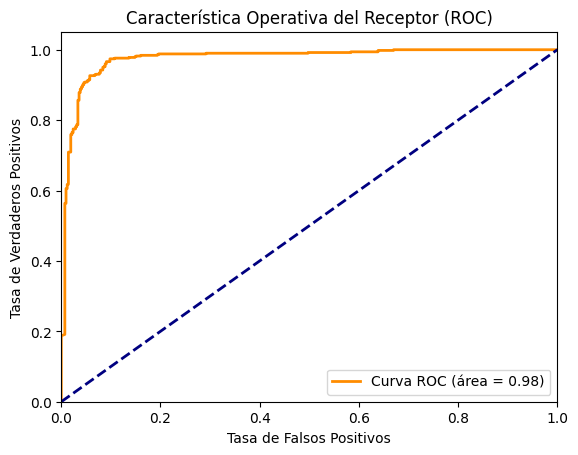

In [ ]:
plot_roc_curve(model, X_test, y_test)

29/29 [==============================] - 0s 3ms/step


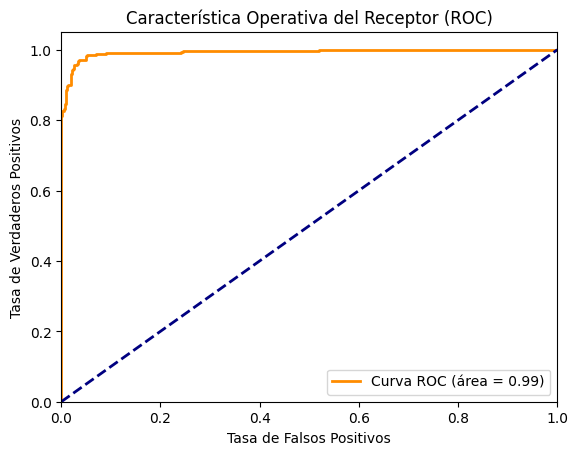

In [ ]:
plot_roc_curve(model2, X_test, y_test)

# **MAPA DE ACTIVACIÓN DE LOS MODELOS**

In [ ]:
# Cargar y preprocesar la imagen 
def load_and_preprocess_image(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE) 
    img = cv2.resize(img, (64, 64))  
    img = img / 255.0 
    img = np.expand_dims(img, axis=-1)  
    img = np.expand_dims(img, axis=0)  
    return img



In [ ]:
# Definir la función Grad-CAM
def get_gradcam(model, img_array, layer_name):
    grad_model = Model(
        inputs=[model.inputs],
        outputs=[model.get_layer(layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, 0]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs.numpy()[0]
    pooled_grads = pooled_grads.numpy()

    for i in range(pooled_grads.shape[-1]):
        conv_outputs[:, :, i] *= pooled_grads[i]

    heatmap = np.mean(conv_outputs, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)

    return heatmap

In [ ]:
def display_gradcam(img, heatmap, alpha=0.6):
    heatmap = cv2.resize(heatmap, (img.shape[2], img.shape[1]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    superimposed_img = heatmap * alpha + img[0, :, :, 0][:, :, np.newaxis] * 255
    superimposed_img = np.uint8(superimposed_img)
    return superimposed_img

In [ ]:
# Listar las capas del Modelo 1
print("Layers of Model 1:")
for layer in model.layers:
    print(layer.name)

Layers of Model 1:
conv2d
max_pooling2d
conv2d_1
max_pooling2d_1
flatten
dense


In [ ]:
# Listar las capas del Modelo 2
print("Layers of Model 2:")
for layer in model2.layers:
    print(layer.name)

Layers of Model 2:
conv2d_2
max_pooling2d_2
dropout
conv2d_3
max_pooling2d_3
dropout_1
conv2d_4
max_pooling2d_4
dropout_2
flatten_1
dense_1
dropout_3
dense_2


In [ ]:
# Cargar la imagen
image_path = '/content/EJ GL.jpg'
img_array = load_and_preprocess_image(image_path)

In [ ]:
image_path2 = '/content/PRUEBA GL.png' 
img_array2 = load_and_preprocess_image(image_path2)

In [ ]:
# Lista de imágenes
images = [(img_array, 'EJ GL.jpg'), (img_array2, 'PRUEBA GL.png')]


In [ ]:
# Generar y visualizar Grad-CAM para cada modelo
layer_names_model1 = ['conv2d', 'conv2d_1']  
layer_names_model2 = ['conv2d_2', 'conv2d_3', 'conv2d_4']  


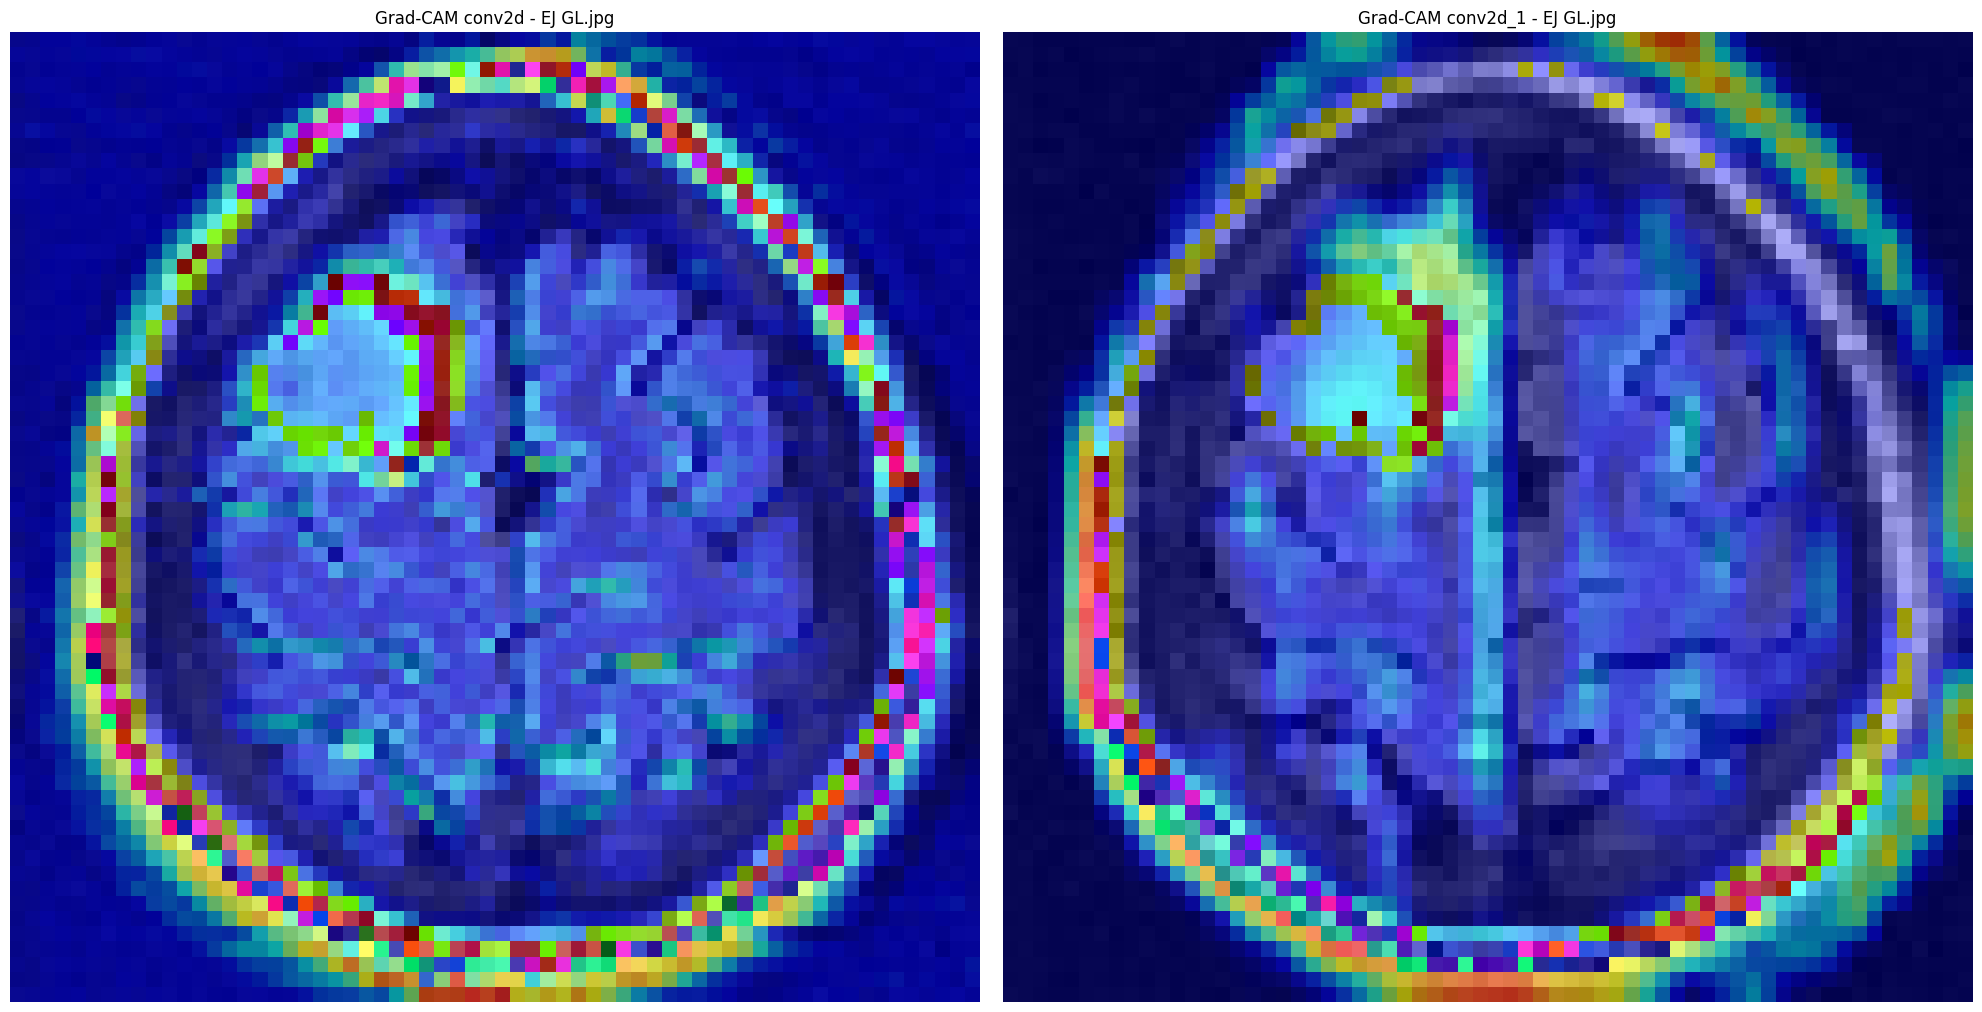

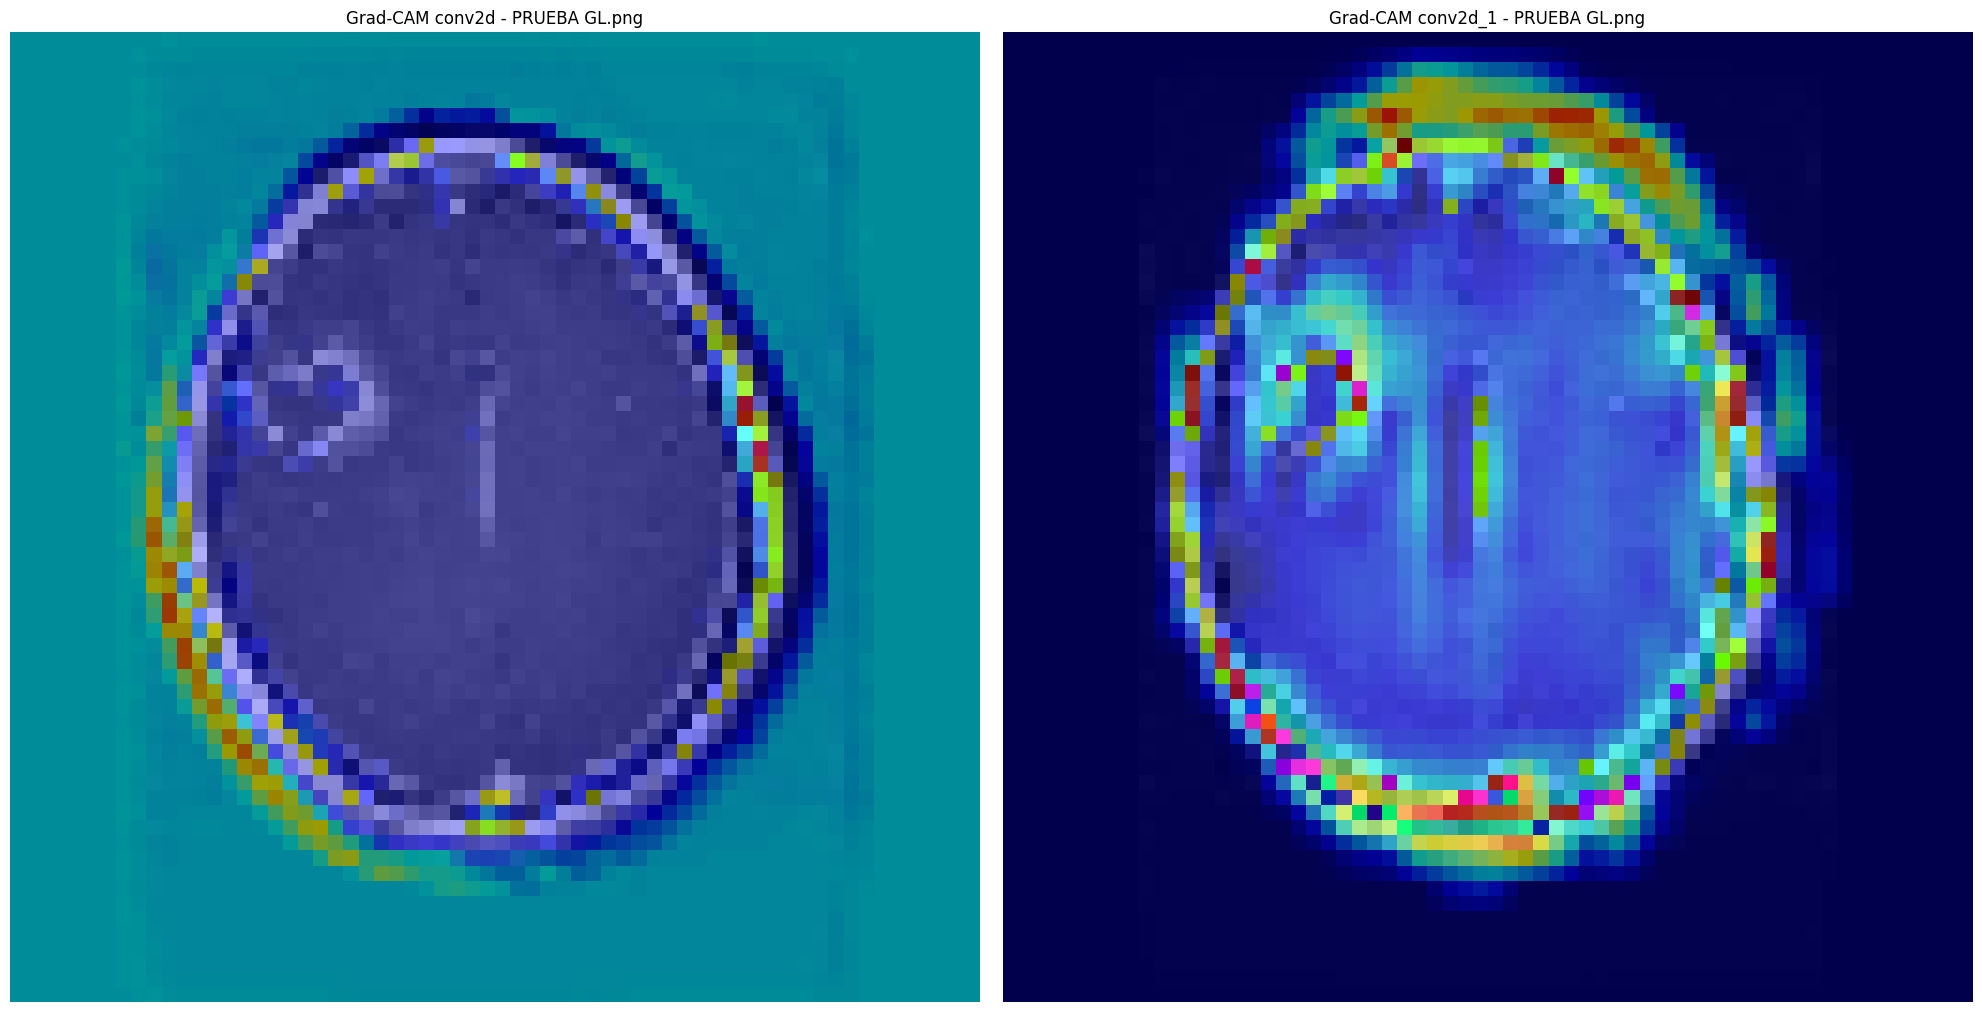

In [ ]:
# Para Modelo 1
for img_array, img_name in images:
    plt.figure(figsize=(20, 10))
    for i, layer_name in enumerate(layer_names_model1):
        heatmap = get_gradcam(model, img_array, layer_name)
        superimposed_img = display_gradcam(img_array, heatmap)
        plt.subplot(1, len(layer_names_model1), i+1)
        plt.title(f'Grad-CAM {layer_name} - {img_name}')
        plt.imshow(superimposed_img)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

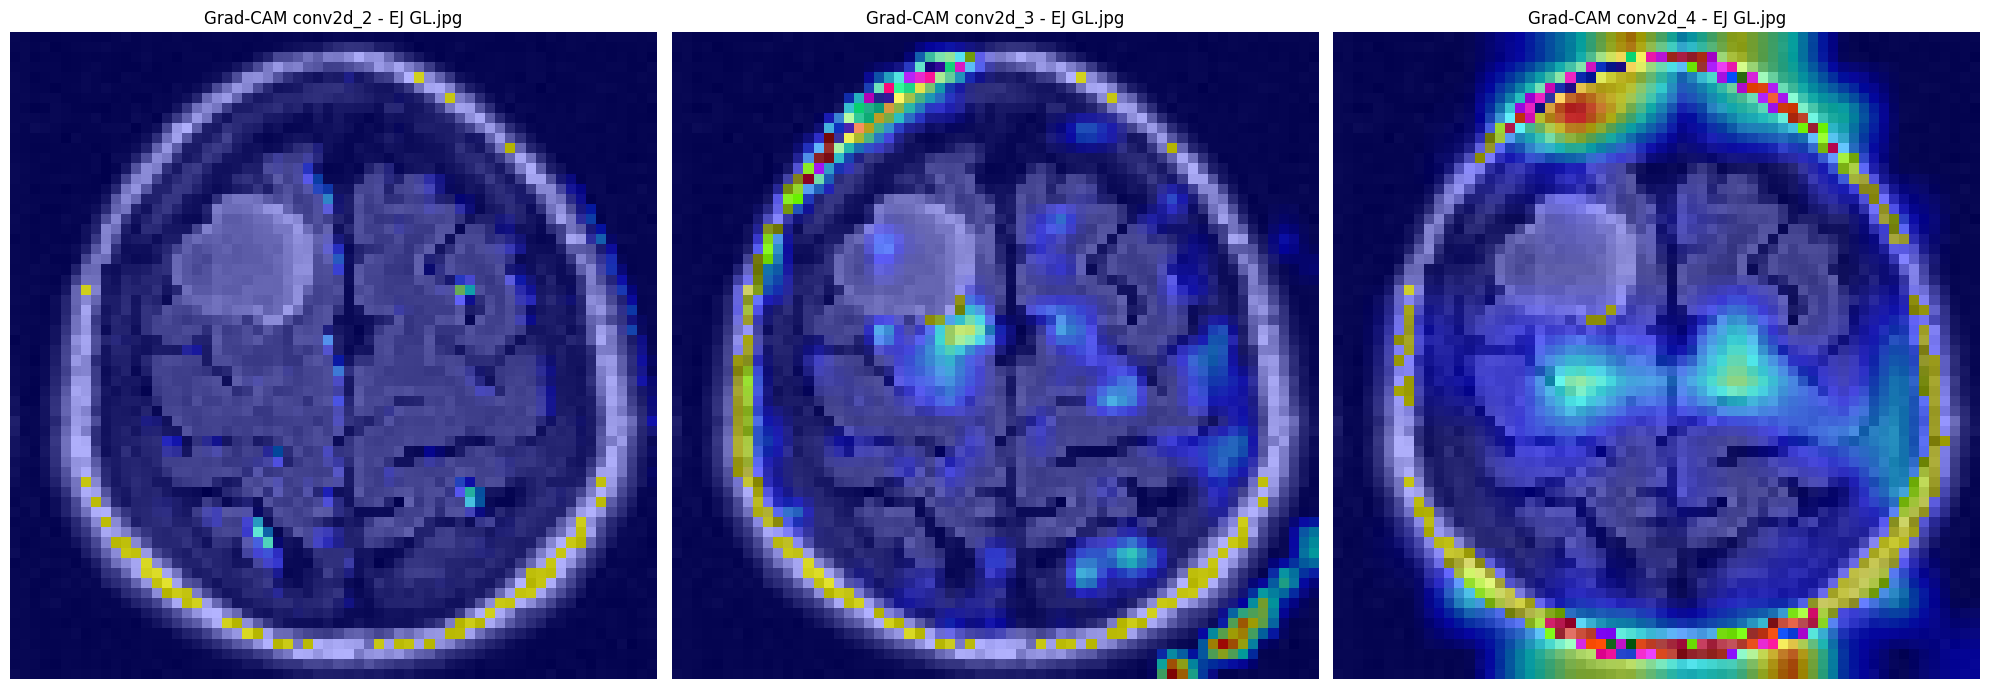

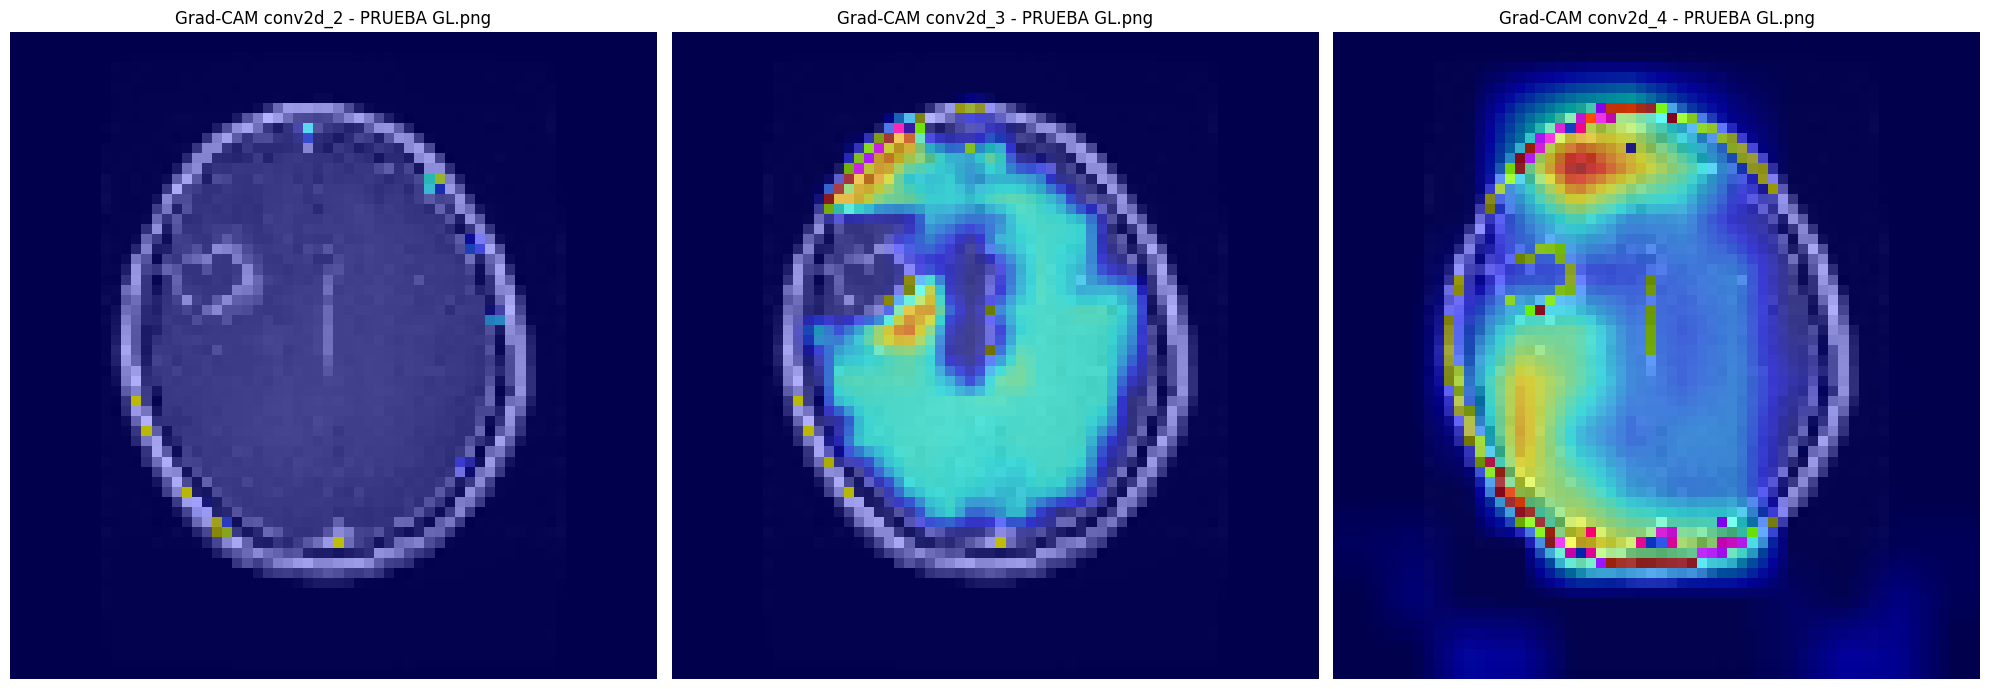

In [ ]:
# Para Modelo 2
for img_array, img_name in images:
    plt.figure(figsize=(20, 10))
    for i, layer_name in enumerate(layer_names_model2):
        heatmap = get_gradcam(model2, img_array, layer_name)
        superimposed_img = display_gradcam(img_array, heatmap)
        plt.subplot(1, len(layer_names_model2), i+1)
        plt.title(f'Grad-CAM {layer_name} - {img_name}')
        plt.imshow(superimposed_img)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# **ANÁLISIS DE ERRORES**

In [ ]:
def analyze_errors(model, X_test, y_test):
    # Obtener las probabilidades de las predicciones
    y_pred_prob = model.predict(X_test)
    # Convertir las probabilidades en etiquetas binarias
    y_pred = (y_pred_prob > 0.5).astype(int)

    # Crear un DataFrame para comparar las etiquetas reales con las predichas
    results = pd.DataFrame({
        'Etiqueta Actual': y_test.flatten(),
        'Etiqueta Predicha': y_pred.flatten()
    })

    # Convertir etiquetas numéricas a categorías para mejor visualización
    results['Etiqueta Actual'] = results['Etiqueta Actual'].map({0: 'Healthy', 1: 'Tumor'})
    results['Etiqueta Predicha'] = results['Etiqueta Predicha'].map({0: 'Healthy', 1: 'Tumor'})

    # Identificar predicciones incorrectas
    incorrect_predictions = results[results['Etiqueta Actual'] != results['Etiqueta Predicha']]

    # Mostrar resultados
    print("Número de predicciones incorrectas:", len(incorrect_predictions))
    print(incorrect_predictions)
    print("\n")

In [ ]:
# Aplicar la función a cada modelo
print("Errores en Modelo 1:")
analyze_errors(model, X_test, y_test)

Errores en Modelo 1:
29/29 [==============================] - 0s 2ms/step
Número de predicciones incorrectas: 57
    Etiqueta Actual Etiqueta Predicha
26            Tumor           Healthy
29          Healthy             Tumor
31          Healthy             Tumor
55          Healthy             Tumor
120         Healthy             Tumor
132         Healthy             Tumor
156           Tumor           Healthy
185         Healthy             Tumor
194         Healthy             Tumor
230           Tumor           Healthy
231           Tumor           Healthy
254         Healthy             Tumor
256         Healthy             Tumor
275         Healthy             Tumor
279         Healthy             Tumor
282         Healthy             Tumor
339           Tumor           Healthy
353         Healthy             Tumor
370         Healthy             Tumor
372         Healthy             Tumor
399           Tumor           Healthy
423         Healthy             Tumor
488         H

In [ ]:
print("Errores en Modelo 2:")
analyze_errors(model2, X_test, y_test)

Errores en Modelo 2:
29/29 [==============================] - 0s 3ms/step
Número de predicciones incorrectas: 33
    Etiqueta Actual Etiqueta Predicha
26            Tumor           Healthy
27          Healthy             Tumor
29          Healthy             Tumor
33            Tumor           Healthy
55          Healthy             Tumor
78            Tumor           Healthy
107         Healthy             Tumor
172           Tumor           Healthy
230           Tumor           Healthy
242           Tumor           Healthy
263           Tumor           Healthy
275         Healthy             Tumor
331           Tumor           Healthy
332           Tumor           Healthy
339           Tumor           Healthy
353         Healthy             Tumor
373           Tumor           Healthy
399           Tumor           Healthy
437           Tumor           Healthy
510         Healthy             Tumor
521           Tumor           Healthy
537           Tumor           Healthy
575         H

# **VALIDACIÓN CRUZADA**

In [ ]:
# Definición de los modelos
def create_model1():
    model = Sequential([
        Input(shape=(64,64,1)),
        Conv2D(16, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Conv2D(32, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Flatten(),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
    return model

def create_model2():
    model = Sequential([
        Input(shape=(64, 64, 1)),
        Conv2D(16, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Dropout(0.2),
        Conv2D(32, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Dropout(0.3),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Dropout(0.4),
        Flatten(),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
# Número de pliegues
n_splits = 5

# Inicializar StratifiedKFold
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Variables para almacenar los resultados
results_model1 = []
results_model2 = []

In [ ]:
for fold, (train_index, val_index) in enumerate(skf.split(X_train, y_train)):
    print(f"Fold {fold+1}/{n_splits}")

    # Datos de entrenamiento y validación para este pliegue
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    # Modelo 1
    model1 = create_model1()
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min')
    history1 = model1.fit(X_train_fold, y_train_fold, epochs=50,
                          validation_data=(X_val_fold, y_val_fold),
                          batch_size=32, callbacks=[early_stopping], verbose=0)

    loss, accuracy = model1.evaluate(X_test, y_test, verbose=0)
    print(f"Modelo 1 - Loss: {loss}, Accuracy: {accuracy}")
    results_model1.append((loss, accuracy))

    # Modelo 2
    model2 = create_model2()
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min')
    history2 = model2.fit(X_train_fold, y_train_fold, epochs=50,
                          validation_data=(X_val_fold, y_val_fold),
                          batch_size=32, callbacks=[early_stopping], verbose=0)

    loss, accuracy = model2.evaluate(X_test, y_test, verbose=0)
    print(f"Modelo 2 - Loss: {loss}, Accuracy: {accuracy}")
    results_model2.append((loss, accuracy))

Fold 1/5
Epoch 36: early stopping
Modelo 1 - Loss: 0.2347724884748459, Accuracy: 0.9347826242446899
Epoch 35: early stopping
Modelo 2 - Loss: 0.14389994740486145, Accuracy: 0.947826087474823
Fold 2/5
Epoch 30: early stopping
Modelo 1 - Loss: 0.3504561483860016, Accuracy: 0.9195652008056641
Epoch 46: early stopping
Modelo 2 - Loss: 0.09804853051900864, Accuracy: 0.9619565010070801
Fold 3/5
Epoch 17: early stopping
Modelo 1 - Loss: 0.24636752903461456, Accuracy: 0.904347836971283
Epoch 46: early stopping
Modelo 2 - Loss: 0.1430172473192215, Accuracy: 0.949999988079071
Fold 4/5
Epoch 25: early stopping
Modelo 1 - Loss: 0.25312381982803345, Accuracy: 0.9315217137336731
Epoch 31: early stopping
Modelo 2 - Loss: 0.15618550777435303, Accuracy: 0.9434782862663269
Fold 5/5
Epoch 34: early stopping
Modelo 1 - Loss: 0.2524639368057251, Accuracy: 0.938043475151062
Modelo 2 - Loss: 0.11194484680891037, Accuracy: 0.9630434513092041


In [ ]:
# Resultados finales
results_model1 = np.array(results_model1)
results_model2 = np.array(results_model2)

In [ ]:
# Resultados del modelo 1
results_model1 = np.array(results_model1)
loss_model1_mean = results_model1[:, 0].mean()
loss_model1_std = results_model1[:, 0].std()
accuracy_model1_mean = results_model1[:, 1].mean()
accuracy_model1_std = results_model1[:, 1].std()

# Resultados del modelo 2
results_model2 = np.array(results_model2)
loss_model2_mean = results_model2[:, 0].mean()
loss_model2_std = results_model2[:, 0].std()
accuracy_model2_mean = results_model2[:, 1].mean()
accuracy_model2_std = results_model2[:, 1].std()

In [ ]:
# Imprimir resultados finales
print("Modelo 1 - Resultados finales:")
print(f"Loss: {loss_model1_mean} +/- {loss_model1_std}")
print(f"Accuracy: {accuracy_model1_mean} +/- {accuracy_model1_std}")

Modelo 1 - Resultados finales:
Loss: 0.2674367845058441 +/- 0.042028874994455505
Accuracy: 0.9256521701812744 +/- 0.01234736394113247


In [ ]:
print("Modelo 2 - Resultados finales:")
print(f"Loss: {loss_model2_mean} +/- {loss_model2_std}")
print(f"Accuracy: {accuracy_model2_mean} +/- {accuracy_model2_std}")


Modelo 2 - Resultados finales:
Loss: 0.13061921596527098 +/- 0.021878326717181096
Accuracy: 0.953260862827301 +/- 0.007838138199684421


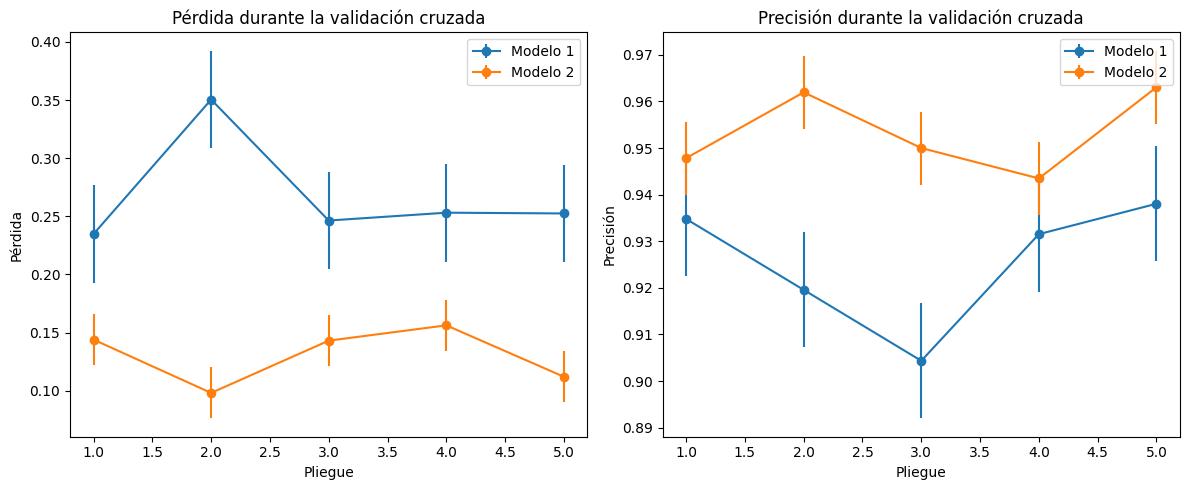

In [ ]:
# Graficar los resultados
plt.figure(figsize=(12, 5))

# Gráfico de pérdida
plt.subplot(1, 2, 1)
plt.errorbar(range(1, n_splits + 1), results_model1[:, 0], yerr=loss_model1_std, fmt='-o', label='Modelo 1')
plt.errorbar(range(1, n_splits + 1), results_model2[:, 0], yerr=loss_model2_std, fmt='-o', label='Modelo 2')
plt.xlabel('Pliegue')
plt.ylabel('Pérdida')
plt.title('Pérdida durante la validación cruzada')
plt.legend()

# Gráfico de precisión
plt.subplot(1, 2, 2)
plt.errorbar(range(1, n_splits + 1), results_model1[:, 1], yerr=accuracy_model1_std, fmt='-o', label='Modelo 1')
plt.errorbar(range(1, n_splits + 1), results_model2[:, 1], yerr=accuracy_model2_std, fmt='-o', label='Modelo 2')
plt.xlabel('Pliegue')
plt.ylabel('Precisión')
plt.title('Precisión durante la validación cruzada')
plt.legend()

plt.tight_layout()
plt.show()